*Проект выполнила Мария Еремина*

## Часть 1. Описание набора данных и признаков

### Постановка задачи и ее ценность

На данный момент существует множество онлайн-сервисов для определения подозрительных и опасных сайтов, достаточно лишь вбить адрес сайта в строку поиска. Большинство таких сервисов обращаются в крупные базы черных списков: Яндекс, VirusTotal, Роскомнадзор (да-да, там тоже ищут), Google, из которых в каждом более 500000 адресов. Другие же сервисы дополнительно сканируют сам сайт на вирусы, взлом и недобросовестную рекламу, а также проводят поведенческий анализ, имитируя пользователей. Но проблема в том, что мошеннические URL генерируются каждый день, и пока такой сайт "дойдет" до блэк-листов, он может навредить не одному пользователю, а проверка на вредоносный код - рисковая и технически затратная процедура. <br/>
Довольно часто можно визуально определить ссылку на подозрительный сайт - домен может быть слишком длинным, содержать множество несвязанных символов и т.д. Попробуем решить задачу определения опасного сайта только по его URL.

### Источник данных

Данные взяты из <a href='https://github.com/faizann24/Using-machine-learning-to-detect-malicious-URLs'>репозитория</a> на Github. Автор собирал адреса из открытых списков опасных и безопасных сайтов.

### Описание набора данных

Набор данных состоит из двух столбцов:<br/><br/>
'<b>url</b>' - строка с адресом сайта (не содержит названия протокола)<br/>
'<b>label</b>' - значение целевой переменной, содержит метки 'good' и 'bad', определяющие безопасен сайт или нет.<br/><br/>
Будем решать задачу бинарной классификации.

## Часть 2. Первичный анализ данных

Для начала импортируем необходимые библиотеки:

In [15]:
import numpy as np
import pandas as pd

from scipy.sparse import *

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, validation_curve, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

# библиотеки для дальнейшей обработки URL
from urllib.parse import urlparse
import tldextract
import ipaddress as ip
import re, string

# игнорируем warnings
import warnings
warnings.filterwarnings("ignore")

from pylab import rcParams
rcParams['figure.figsize'] = 12, 9
rcParams['axes.titlesize'] = 16
sns.set(style='darkgrid', palette='deep', color_codes=True, font_scale=1.5)

Далее загрузим наши данные, посмотрим на размер набора и первые 10 строк.

In [2]:
data_df = pd.read_csv("data/data.csv")
print('Полная выборка содержит {} строк.'.format(data_df.shape[0]))
data_df.head(10)

Полная выборка содержит 420464 строк.


,url,label
0,diaryofagameaddict.com,bad
1,espdesign.com.au,bad
2,iamagameaddict.com,bad
3,kalantzis.net,bad
4,slightlyoffcenter.net,bad
5,toddscarwash.com,bad
6,tubemoviez.com,bad
7,ipl.hk,bad
8,crackspider.us/toolbar/install.php?pack=exe,bad
9,pos-kupang.com/,bad


Посмотрим, есть ли пропуски в данных и дублирующиеся строки. Если повторы есть, выведем число дублей, а затем удалим все, кроме первого вхождения.

In [3]:
count_duplicates = data_df.shape[0] - data_df.drop_duplicates().shape[0]
data_df = data_df.drop_duplicates().reset_index(drop=True)

print('Полная выборка содержит {} дублирующихся строк.'.format(count_duplicates))
print('Количество пропусков:')
data_df.isnull().sum()

Полная выборка содержит 9216 дублирующихся строк.
Количество пропусков:


url      0
label    0
dtype: int64

Отлично, пропусков в данных нет, и мы удалили все повторы.
<br>
<br>
Теперь преобразуем значения целевой переменной `label`. Обозначим `good` = 0 и `bad` = 1, так как предсказывать мы будем именно "плохие сайты".

In [4]:
data_df['label'] = data_df['label'].map({'bad': 1, 'good': 0})

Посмотрим на распределение целевого класса `label`.

In [5]:
data_df['label'].value_counts()

0    344800
1     66448
Name: label, dtype: int64

Видим несбалансированность классов - "плохих" строк в 5 раз меньше, чем "хороших".

Также на этом этапе выполним небольшую предобработку - поделим все наши данные на обучающую и тестовую выборки - 70% и 30% данных соответственно. Используем для этого метод `train_test_split` со следующими параметрами:
 - 'stratify' = data_df['label']. Необходимо для соотнесения количества целевых меток в выборках.
 - 'random_state' = 17
 - 'test_size' = 0.3
 - 'shuffle' = True


In [6]:
train, test = train_test_split(data_df, random_state = 17, 
                               test_size = 0.3, shuffle = True, 
                               stratify = data_df['label'])
print('Тренировочная выборка:')
print('Класс 0 -  {}, класс 1 - {}.'.format(train['label'].value_counts()[0], train['label'].value_counts()[1]))
print('Тестовая выборка:')
print('Класс 0 -  {}, класс 1 - {}.'.format(test['label'].value_counts()[0], test['label'].value_counts()[1]))

Тренировочная выборка:
Класс 0 -  241359, класс 1 - 46514.
Тестовая выборка:
Класс 0 -  103441, класс 1 - 19934.


## Часть 3. Первичный визуальный анализ

Так как на данном этапе у нас всего лишь один признак - строка URL. Попробуем выделить из нее следующие вещи:
<br>
1. Длина строки. В длинном URL легче спрятать подозрительные элементы и перенаправления.
2. Длина домена. 
3. Число цифр в строке. В хороших названиях сайтов редко используются цифры, только если они не значимы для названия, например, год или код города. Чем меньше цифр и больше осмысленных слов, тем понятнее куда мы переходим.
4. Является ли домен IP-адресом. Если вместо домена используется IP, то возможно кто-то пытается похитить данные пользователей.
5. Количество субдоменов.
6. Число редиректов (количество '//').
7. Содержит ли строка адреса запрос (query).
8. Символ '@'. Все, что находится перед этим символом, браузер игнорирует, и настоящая ссылка может быть скрыта от пользователя.
9. Количество слэшей ('/'). Чем меньше папок, тем лучше.
10. Есть ли в имени домена буквы в верхнем регистре.
<br>
На этом пока остановимся.   
<br>
Воспользуемся библиотеками <a href='https://docs.python.org/3/library/urllib.parse.html'>urllib</a> и <a href='https://pypi.org/project/tldextract/'>tldextract</a>, чтобы распарсить URL. На примере одной строки посомтрим, что вернут методы `urlparse` и `tldextract.extract`.

In [7]:
urlparse(train['url'].iloc[56])

ParseResult(scheme='', netloc='', path='absoluteastronomy.com/topics/Smooth_jazz', params='', query='', fragment='')

In [8]:
tldextract.extract(train['url'].iloc[56])

ExtractResult(subdomain='', domain='absoluteastronomy', suffix='com')

In [9]:
# метод для выяснения, является ли строка IP-адресом
def is_ip_address(domain):
    try:
        if ip.ip_address(domain):
            return 1
    except:
        return 0
    
# метод, принимающий строку и возвращающий количество элементов, 
# разделенных точкой (количество субдоменов)
def count_subdomains(subdomain):
    if subdomain.count('.') > 0:
        return subdomain.count('.') + 1
    elif len(subdomain) > 0:
        return 1
    else:
        return 0 

In [10]:
# заведем новый DataFrame и скопируем в него train
new_df = train.copy()

# заведем 2 столбца для хранения URL после парсинга
new_df['extract'] = new_df['url'].apply(tldextract.extract)
new_df['urlparse'] = new_df['url'].apply(urlparse)

# посчитаем длину домена и самого URL
new_df['url_length'] = new_df['url'].apply(len)
new_df['domain_length'] = new_df['extract'].apply(lambda x: len(x.domain))

# число цифр в домене
new_df['count_digits_in_domain'] = new_df['extract'].apply(lambda x: len(re.findall('(\d+)', x.domain)))

# число субдоменов
new_df['count_subdomains'] = new_df['extract'].apply(lambda x: count_subdomains(x.subdomain))

new_df['domain_is_ip'] = new_df['extract'].apply(lambda x: is_ip_address(x.domain))

# подсчитаем число символов '@', '/', '//'
new_df['count_slash'] = new_df['url'].apply(lambda x: x.count('/'))
new_df['count_d_slash'] = new_df['url'].apply(lambda x: x.count('//'))
new_df['count_@'] = new_df['url'].apply(lambda x: x.count('@'))

# есть ли query
new_df['have_query'] = new_df['urlparse'].apply(lambda x: 0 if x.query == '' else 1)

# буквы в верхнем регистре в домене
caps = re.compile('[A-Z]+')
new_df['have_caps'] = new_df['extract'].apply(lambda x: 1 if len(caps.findall(x.domain)) > 0 else 0)

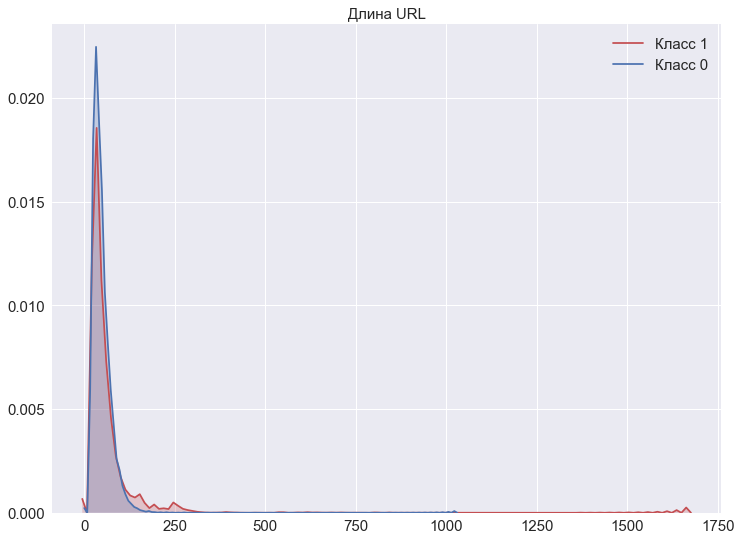

In [16]:
sns.kdeplot(new_df[new_df['label'] == 1]['url_length'], shade=True, color='r')
sns.kdeplot(new_df[new_df['label'] == 0]['url_length'], shade=True)
plt.title("Длина URL", fontsize=15)
plt.legend(['Класс 1', 'Класс 0']); 

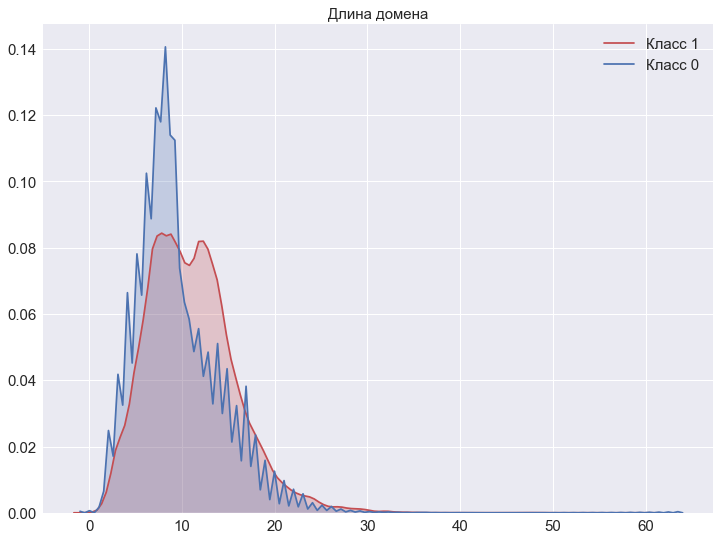

In [168]:
sns.kdeplot(new_df[new_df['label'] == 1]['domain_length'], shade=True, color='r')
sns.kdeplot(new_df[new_df['label'] == 0]['domain_length'], shade=True)
plt.title("Длина домена", fontsize=15)
plt.legend(['Класс 1', 'Класс 0']); 


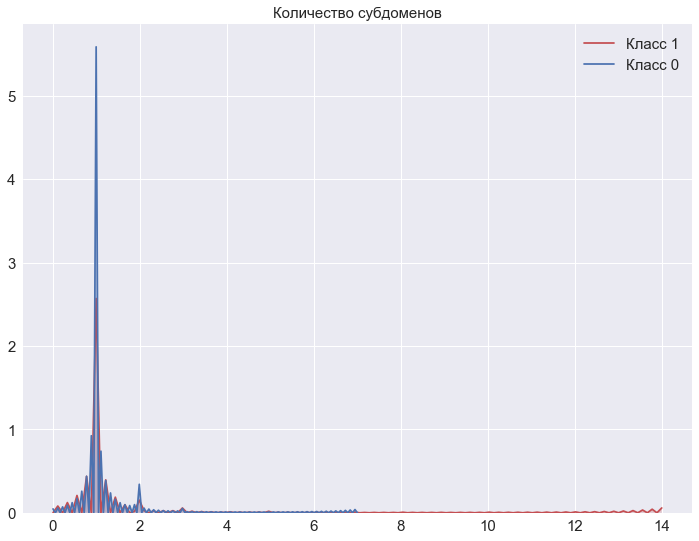

In [17]:
sns.kdeplot(new_df[new_df['label'] == 1]['count_subdomains'], shade=True, color='r')
sns.kdeplot(new_df[new_df['label'] == 0]['count_subdomains'], shade=True)
plt.title("Количество субдоменов", fontsize=15)
plt.legend(['Класс 1', 'Класс 0']); 

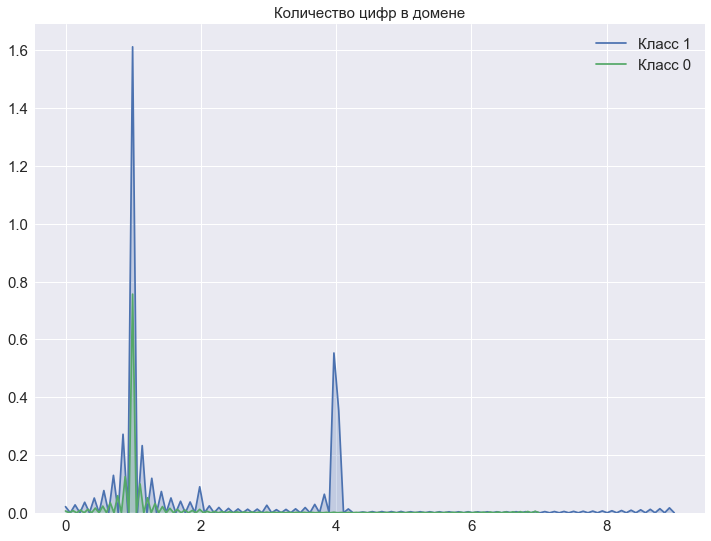

In [18]:
sns.kdeplot(new_df[new_df['label'] == 1]['count_digits_in_domain'], shade=True)
sns.kdeplot(new_df[new_df['label'] == 0]['count_digits_in_domain'], shade=True)
plt.title("Количество цифр в домене", fontsize=15)
plt.legend(['Класс 1', 'Класс 0']); 

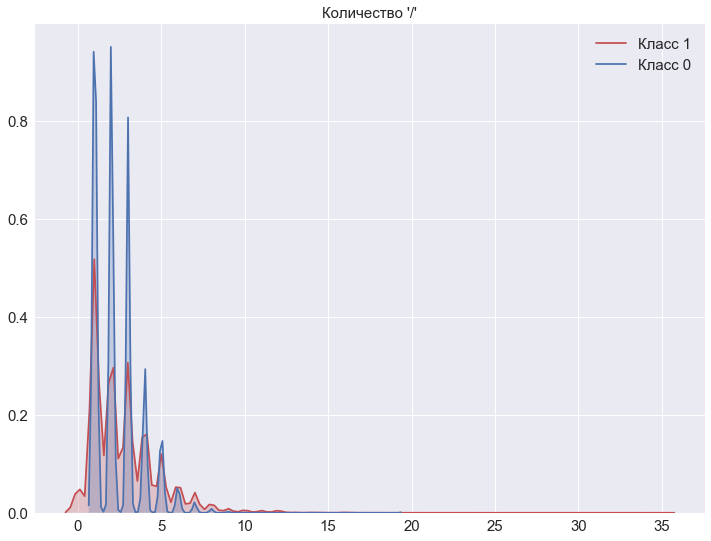

In [19]:
sns.kdeplot(new_df[new_df['label'] == 1]['count_slash'], shade=True, color='r')
sns.kdeplot(new_df[new_df['label'] == 0]['count_slash'], shade=True)
plt.title("Количество '/'", fontsize=15)
plt.legend(['Класс 1', 'Класс 0']);

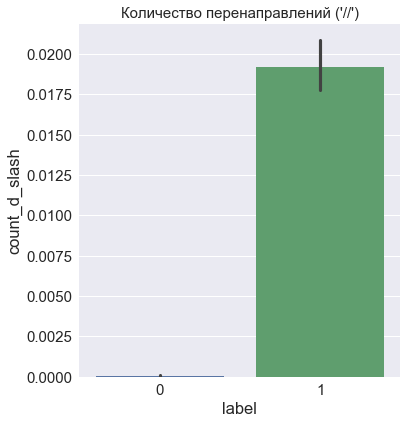

In [20]:
sns.factorplot(x='label', y='count_d_slash', data=new_df, kind='bar', size=6)
plt.title("Количество перенаправлений ('//')", fontsize=15);

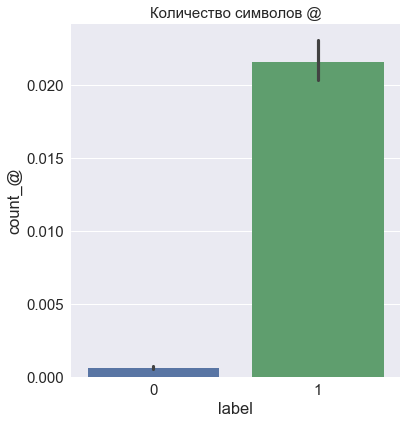

In [21]:
sns.factorplot(x='label', y='count_@', data=new_df, kind='bar', size=6)
plt.title("Количество символов @", fontsize=15);

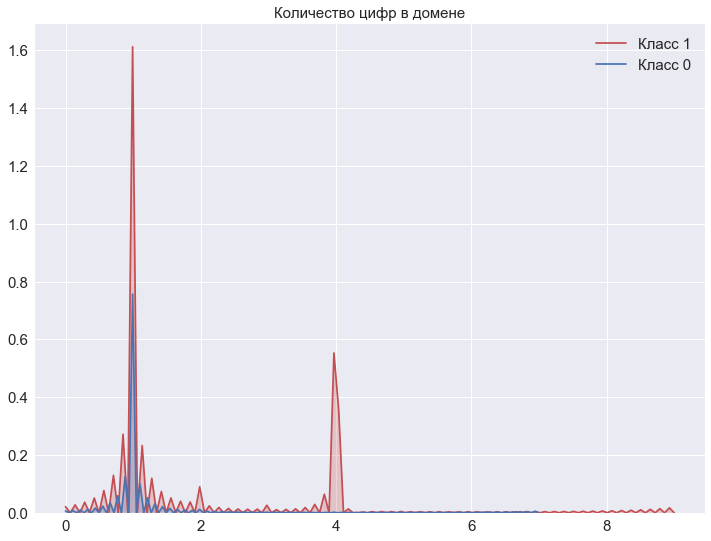

In [22]:
sns.kdeplot(new_df[new_df['label'] == 1]['count_digits_in_domain'], shade=True, color='r')
sns.kdeplot(new_df[new_df['label'] == 0]['count_digits_in_domain'], shade=True)
plt.title("Количество цифр в домене", fontsize=15)
plt.legend(['Класс 1', 'Класс 0']);

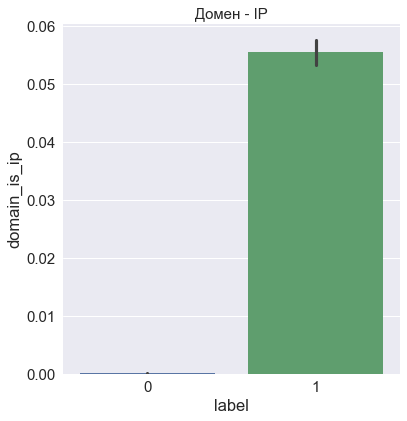

In [23]:
sns.factorplot(x='label', y='domain_is_ip', data=new_df, kind='bar', size=6)
plt.title("Домен - IP", fontsize=15);

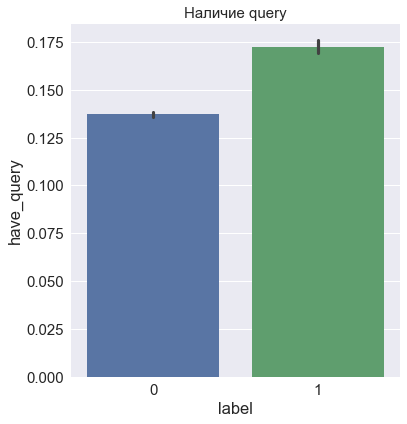

In [24]:
sns.factorplot(x='label', y='have_query', data=new_df, kind='bar', size=6)
plt.title("Наличие query", fontsize=15);

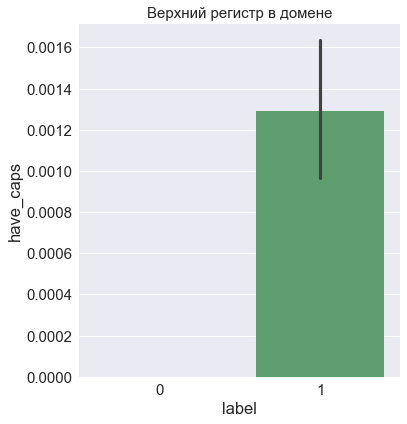

In [25]:
sns.factorplot(x='label', y='have_caps', data=new_df, kind='bar', size=6)
plt.title("Верхний регистр в домене", fontsize=15);

Text(0.5,1,'URL length')

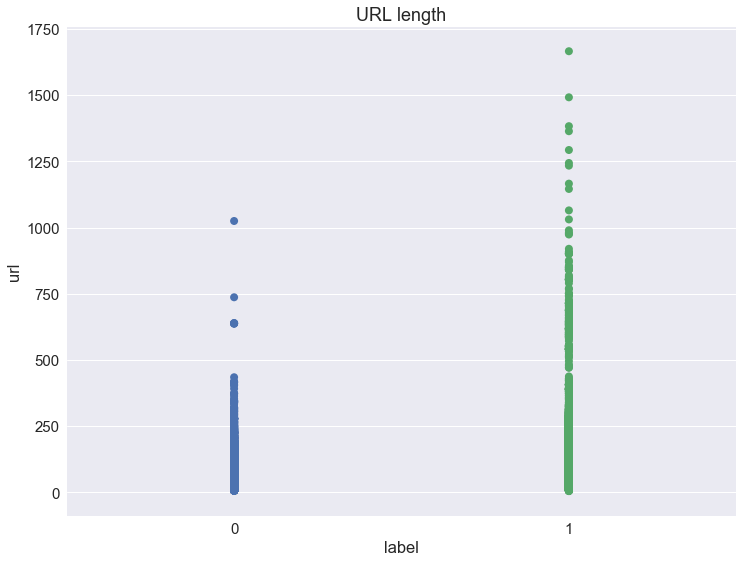

In [26]:
sns.stripplot(x=train['label'], y=train['url'].apply(len), size=8)
plt.title('URL length')

На графике видно, что чем больше URL, тем вероятнее, что он ведет на подозрительный сайт. Размер самой длинной строки - почти 1700 символов.

## Часть 4. Инсайты, найденные зависимости

- Пропусков в данных не обнаружено, удалены 9000 повторяющихся записей. 
- Признаки недобросовестных URL выделяют их на графиках. 
- На всех графиках есть длинный хвост у распределения класса 1 - это связано с природой данных. 
- Длинные URL имеют большую степень опасности, чем URL с длинными доменами.
- Наличие символов в верхнем регистре и замена домена IP-адресом однозначно определяют класс 1. Проблема в том, что объектов с этими признаками очень малое количество относительно выборки.
- График количества знака '/' показал, что страницы, представляющие угрозу, чаще всего пытаются упрятать как можно дальше.
- Собаки уже практически не используются в составлении адресов, но все еще используются мошенниками.
- Так как адреса сайтов - текстовые данные, далее есть смысл использовать Tfidf.


## Часть 5. Выбор метрики

Для оценки качества алгоритма подойдет метрика ROC-AUC - площадь (Area Under Curve) под кривой ошибок (Receiver Operating Characteristic curve). Эта метрика не очень хорошо обобщается для многоклассовой классификации, а для бинарной классификации подходит. Также она зависит от предсказанных вероятностей классов, а не от «жёсткой» дискретной классификации, что хорошо для выборок с дисбалансом классов как в случае этой задачи.

## Часть 6. Выбор модели

В части 3 уже были рассмотрены 9 признаков и возможно было бы использовать деревья решений или их обобщения (случайный лес и градиентный бустинг). Но URL - текстовое поле, поэтому целесообразней преобразовать адреса при помощи Tfidf и обучить логистическую регрессию, а уже после добавлять выявленные признаки и смотреть на качество на кросс-валидации.Убедимся в этом на примере. Разделим new_df на обучающую и валидационную выборки в размере 70% и 30%, соблюдая стратификацию, выделим целевой признак, а затем обучим случайный лес, зафиксировав `random_state` = 17. Оценим качество на валидационной выборке.

In [27]:
new_df.drop(['url', 'extract', 'urlparse'], axis=1, inplace=True)

In [28]:
X_train, X_valid, y_train, y_valid = train_test_split(new_df.drop('label', axis=1), new_df['label'], 
                                                    test_size=0.3, random_state=17, stratify=new_df['label'])

In [29]:
tree = RandomForestClassifier(random_state=17).fit(X_train, y_train)
y_tree_pred = tree.predict(X_valid)

In [30]:
print('Случайный лес. ROC-AUC: {}'.format(roc_auc_score(y_valid, y_tree_pred)))

Случайный лес. ROC-AUC: 0.7124652717223076


Теперь обучим логистическую регрессию на тех же данных. Среди фич есть неотмасштабированные признаки, что скажется на качестве.

In [31]:
logit = LogisticRegression(random_state=17).fit(X_train, y_train)
y_logit_pred = logit.predict(X_valid)

In [32]:
print('Логистическая регрессия на 9 признаках. ROC-AUC: {}'.format(roc_auc_score(y_valid, y_logit_pred)))

Логистическая регрессия на 9 признаках. ROC-AUC: 0.555812818185839


Как и ожидалось, результат чуть лучше случайного выбора. Преобразуем URL-адреса в матрицу Tfidf  и повторим разделение данных, обучение и оценку качества логистической регрессии.

In [33]:
X_train, X_valid, y_train, y_valid = train_test_split(train['url'], new_df['label'], 
                                                      test_size=0.3, random_state=17, stratify=new_df['label'])

In [34]:
# обучим Tfidf с униграммами на тренировочной выборке, а затем преобразуем тренировочную и валидационную выборки
tfidf = TfidfVectorizer(ngram_range=(1, 1), max_features=50000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_valid_tfidf = tfidf.transform(X_valid)

In [35]:
logit = LogisticRegression(random_state=17).fit(X_train_tfidf, y_train)
y_tfidf_pred = logit.predict(X_valid_tfidf)

In [36]:
print('Логистическая регрессия на Tfidf. ROC-AUC: {}'.format(roc_auc_score(y_valid, y_tfidf_pred)))

Логистическая регрессия на Tfidf. ROC-AUC: 0.8988446254116486


Как видно, качество повысилось на 20% в сравнении со случайным лесом. И это без подбора гиперпараметров Tfidf и логистической регресиии.

## Часть 7. Предобработка данных

Tfidf учитывает вклады слов, но не учитывает их порядок. Это не имеет значения в контексте предложения, но для URL порядок составных частей важен. <img src='../../img/URL.png'>

1. Используемый протокол
2. Имя хоста
3. Субдомен
4. Доменное имя
5. Домен верхнего уровня (суффикс)
6. Путь
7. Параметр и значение

Поделим URL на 4 части - имя хоста, доменное имя, suffix и путь.

In [37]:
url_df = pd.DataFrame()

# парсим строку как и в предыдущий раз
url_df['extract'] = train['url'].apply(tldextract.extract)
url_df['urlparse'] = train['url'].apply(urlparse)

# достаем 4 текстовых признака
url_df['hostname'] = url_df['urlparse'].apply(lambda x: x.path.split('/')[0])
url_df['suffix'] = url_df['extract'].apply(lambda x: x.suffix.replace('.', ' '))
url_df['path'] = url_df['urlparse'].apply(lambda x: ''.join([s + ' ' for s in x.path.split('/')[1:]]).strip())
url_df['domain'] = url_df['extract'].apply(lambda x: x.domain)

Посмотрим первые 10 строк.

In [38]:
url_df.drop(['extract', 'urlparse'], axis=1).head(10)

,hostname,suffix,path,domain
408863,liftaccessory.com,com,knby545,liftaccessory
180239,arashian.com,com,index.php,arashian
276291,lionfox.com,com,sessions EekAMouse ras30616.htm,lionfox
170462,allmusic.com,com,artist ray-charles-p3876,allmusic
296274,mylife.com,com,zip-codes b3-7407,mylife
51444,brit-actors.livejournal.com,com,,livejournal
151104,uk.linkedin.com,com,in robertwilliams100,linkedin
378742,zoominfo.com,com,people Truesdale_William_155111015.aspx,zoominfo
380489,yugioh.wikia.com,com,wiki YAKUSOKU_NO_MELODY,wikia
83983,ezinearticles.com,com,,ezinearticles


Поделим выборки на обучающую и валидационную.

In [39]:
X_train, X_valid, y_train, y_valid = train_test_split(url_df.drop(['extract', 'urlparse'], axis=1), 
                                                      new_df['label'], 
                                                      test_size=0.3, 
                                                      random_state=17, 
                                                      stratify=new_df['label'])

Обучим на четырех получившихся признака обучающей выборки Tfidf и преобразуем валидационную, затем соберем все в sparse_matrix.

In [40]:
tfidf = TfidfVectorizer(ngram_range=(1, 1), max_features=50000)
train_1 = tfidf.fit_transform(X_train['hostname'])
valid_1 = tfidf.transform(X_valid['hostname'])
train_2 = tfidf.fit_transform(X_train['suffix'])
valid_2 = tfidf.transform(X_valid['suffix'])
train_3 = tfidf.fit_transform(X_train['path'])
valid_3 = tfidf.transform(X_valid['path'])
train_4 = tfidf.fit_transform(X_train['domain'])
valid_4 = tfidf.transform(X_valid['domain'])

In [41]:
X_train_sparse = csr_matrix(hstack([train_1, train_2, train_3, train_4]))
X_valid_sparse = csr_matrix(hstack([valid_1, valid_2, valid_3, valid_4]))

Обучим логистическую регрессию с параметрами по умолчанию и проверим качество.

In [42]:
logit = LogisticRegression(random_state=17).fit(X_train_sparse, y_train)
y_tfidf_4_pred = logit.predict(X_valid_sparse)

In [43]:
print('Логистическая регрессия на Tfidf с 4 признаками. ROC-AUC: {}'.format(roc_auc_score(y_valid, y_tfidf_4_pred)))

Логистическая регрессия на Tfidf с 4 признаками. ROC-AUC: 0.906218773667799


Качество повысилось.

Количество данных и распределение целевого класса в тренировочной выборке.

In [45]:
url_df.drop(['extract', 'urlparse'], axis=1, inplace=True)

In [46]:
train['label'].shape

(287873,)

In [47]:
train['label'].value_counts()

0    241359
1     46514
Name: label, dtype: int64

Также на этом этапе выделим отложенную выборку, отдадим ей 30% строк, и метки классов поместим в отдельную переменную.

In [48]:
X, y = url_df, train['label']
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, 
                                                        random_state=17, 
                                                        stratify=y)

Размеры отложенной и обучающей выборок после разбиения.

In [49]:
X_train.shape, X_holdout.shape

((230298, 4), (57575, 4))

Заново обучим Tfidf на 4 признаках тренировочной выборки и соединим их в разреженные матрицы.

In [50]:
tfidf = TfidfVectorizer(ngram_range=(1, 1), max_features=50000)
train_1 = tfidf.fit_transform(X_train['hostname'])
holdout_1 = tfidf.transform(X_holdout['hostname'])
train_2 = tfidf.fit_transform(X_train['suffix'])
holdout_2 = tfidf.transform(X_holdout['suffix'])
train_3 = tfidf.fit_transform(X_train['path'])
holdout_3 = tfidf.transform(X_holdout['path'])
train_4 = tfidf.fit_transform(X_train['domain'])
holdout_4 = tfidf.transform(X_holdout['domain'])

In [51]:
X_train_sparse = csr_matrix(hstack([train_1, train_2, train_3, train_4]))
X_holdout_sparse = csr_matrix(hstack([holdout_1, holdout_2, holdout_3, holdout_4]))

## Часть 8. Кросс-валидация и настройка гиперпараметров модели

### Кросс-валидация

При разбиении на фолды необходимо сохранить распределение классов. Это особенно важно, если в классах изначально есть сильный дисбаланс. Для это используем `sklearn.model_selection.StratifiedKFold`. Разбиение будет на 3 фолда. Обязательно фиксируем значение seed для воспроизводимости результата.

In [52]:
skf = StratifiedKFold(random_state=17, n_splits=3, shuffle=True)

Для кросс-валидации подойдет метод `cross_val_score` с параметрами `X=X_train_sparse`, `y=y_train`, `cv=skf`, `scoring='roc_auc'`. 

### Настройка гипермпараметров модели

Для настройки гиперпараметров понадобится `GridSearchCV`. Подбирать будем параметр `C` из `np.logspace(-3, 3, 5)` - силу регуляризации, чем больше коэффициент, тем меньше регуляризация. Помимио этого, нужно будет выставить параметр `class_weight` = 'balanced'. `Random_state` оставим равным 17. Сначала проведем кросс-валидацию с параметрами по умолчанию, затем приступим к настройке, для сравнимости результатов.

In [53]:
np.mean(cross_val_score(logit, X=X_train_sparse, y=y_train, cv=skf, scoring='roc_auc'))

0.9882453358295407

In [54]:
logit = LogisticRegression(random_state=17, class_weight='balanced')
params = {'C': np.logspace(-3, 3, 5)}
grid = GridSearchCV(logit, param_grid=params, cv=skf, scoring='roc_auc').fit(X_train_sparse, y_train)
print('Качество на кросс-валидации: {}'.format(grid.best_score_))
print('Оптимальное значение: {}'.format(grid.best_params_))

Качество на кросс-валидации: 0.9890703855604036
Оптимальное значение: {'C': 31.622776601683793}


Видно яное переобучение, так как для проведения кросс-валидации было отобрано мало данных, а именно объектов с прогнозируемым классом (их вообще мало). Проверим качество на отложенной выборке.

In [55]:
logit = LogisticRegression(random_state=17, class_weight='balanced', C=31.0).fit(X_train_sparse, y_train)
roc_auc_score(y_holdout, logit.predict(X_holdout_sparse))

0.944192512182658

### Настройка параметров Tfidf

Настроим параметры `ngram` = униграммы и биграммы, `max_features` = range(50000, 100001, 10000). Качество посмотрим на отложенной выборке.

In [375]:
scores = []
for n in [1, 2]:
    for max_feat in range(50000, 100001, 10000):
        tfidf = TfidfVectorizer(ngram_range=(1, n), max_features=max_feat)
        train_1 = tfidf.fit_transform(X_train['hostname'])
        holdout_1 = tfidf.transform(X_holdout['hostname'])
        train_2 = tfidf.fit_transform(X_train['suffix'])
        holdout_2 = tfidf.transform(X_holdout['suffix'])
        train_3 = tfidf.fit_transform(X_train['path'])
        holdout_3 = tfidf.transform(X_holdout['path'])
        train_4 = tfidf.fit_transform(X_train['domain'])
        holdout_4 = tfidf.transform(X_holdout['domain'])
        X_train_sparse_cv = csr_matrix(hstack([train_1, train_2, train_3, train_4]))
        X_holdout_sparse_cv = csr_matrix(hstack([holdout_1, holdout_2, holdout_3, holdout_4]))
        logit = LogisticRegression(random_state=17, class_weight='balanced', C=31.0).fit(X_train_sparse_cv, y_train)
        scores.append(roc_auc_score(y_holdout, logit.predict(X_holdout_sparse_cv)))

In [380]:
scores

[0.944192512182658,
 0.94557461162517,
 0.9443679196367312,
 0.9408339184924753,
 0.8997165438611849,
 0.8995326333620395,
 0.9442628357167424,
 0.9447813110333143,
 0.9462685957153257,
 0.9449493455445478,
 0.9422293609351373,
 0.9422707928211167]

In [382]:
np.argmax(scores)

8

Лучшее значение было достигнуто с параметрами `ngram` = (1, 2) и `max_features` = 70000.

In [383]:
# метод для преобразования тренировочной и отложенной выборки
def to_tfidf(train_x, test_x):
    tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=70000)
    train_1 = tfidf.fit_transform(train_x['hostname'])
    holdout_1 = tfidf.transform(test_x['hostname'])
    train_2 = tfidf.fit_transform(train_x['suffix'])
    holdout_2 = tfidf.transform(test_x['suffix'])
    train_3 = tfidf.fit_transform(train_x['path'])
    holdout_3 = tfidf.transform(test_x['path'])
    train_4 = tfidf.fit_transform(train_x['domain'])
    holdout_4 = tfidf.transform(test_x['domain'])
    X_train_sparse_cv = csr_matrix(hstack([train_1, train_2, train_3, train_4]))
    X_holdout_sparse_cv = csr_matrix(hstack([holdout_1, holdout_2, holdout_3, holdout_4]))
    return X_train_sparse_cv, X_holdout_sparse_cv

## Часть 9. Создание новых признаков.

Процесс создания и логическое обоснование приведено в части 3. Будем добавлять бинарные признаки по одному к нашей выборке.

In [400]:
X, y = pd.concat([url_df, new_df], axis=1), train['label']
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, 
                                                            random_state=17, 
                                                            stratify=y)
X_new_train, X_new_holdout = to_tfidf(X_train, X_holdout)


Метрика без новых признаков.

In [390]:
logit = LogisticRegression(random_state=17, class_weight='balanced', C=31.0).fit(X_train, y_train)
roc_auc_score(y_holdout, logit.predict(X_holdout))

0.9422707928211167

Tfidf + Domain is IP

In [407]:
full_X_train = csr_matrix(hstack([X_new_train, X_train[['domain_is_ip']]]))
full_X_test = csr_matrix(hstack([X_new_holdout, X_holdout[['domain_is_ip']]]))
logit = LogisticRegression(random_state=17, class_weight='balanced', C=31.0).fit(full_X_train, y_train)
roc_auc_score(y_holdout, logit.predict(full_X_test))

0.9422811507926117

Tfidf + Верхний регистр

In [409]:
full_X_train = csr_matrix(hstack([X_new_train, X_train[['have_caps']]]))
full_X_test = csr_matrix(hstack([X_new_holdout, X_holdout[['have_caps']]]))
logit = LogisticRegression(random_state=17, class_weight='balanced', C=31.0).fit(full_X_train, y_train)
roc_auc_score(y_holdout, logit.predict(full_X_test))

0.9424857772347468

Tfidf + Наличие query в строке

In [410]:
full_X_train = csr_matrix(hstack([X_new_train, X_train[['have_query']]]))
full_X_test = csr_matrix(hstack([X_new_holdout, X_holdout[['have_query']]]))
logit = LogisticRegression(random_state=17, class_weight='balanced', C=31.0).fit(full_X_train, y_train)
roc_auc_score(y_holdout, logit.predict(full_X_test))

0.9421095545108943

Можно заметить, что добавление новых признаков либо ухудшает модель, либо улучшает на десятитысячные доли, поэтому можно оставить так, как есть.

## Часть 10. Прогноз для тестовой выборки

Для начала приведем тестовую и тренировочные выборки к нужному виду.

In [414]:
# преобразовываем train
train['extract'] = train['url'].apply(tldextract.extract)
train['urlparse'] = train['url'].apply(urlparse)
train['hostname'] = train['urlparse'].apply(lambda x: x.path.split('/')[0])
train['suffix'] = train['extract'].apply(lambda x: x.suffix.replace('.', ' '))
train['path'] = train['urlparse'].apply(lambda x: ''.join([s + ' ' for s in x.path.split('/')[1:]]).strip())
train['domain'] = train['extract'].apply(lambda x: x.domain)

y_train = train['label']

In [413]:
# преобразовываем test
test['extract'] = test['url'].apply(tldextract.extract)
test['urlparse'] = test['url'].apply(urlparse)
test['hostname'] = test['urlparse'].apply(lambda x: x.path.split('/')[0])
test['suffix'] = test['extract'].apply(lambda x: x.suffix.replace('.', ' '))
test['path'] = test['urlparse'].apply(lambda x: ''.join([s + ' ' for s in x.path.split('/')[1:]]).strip())
test['domain'] = test['extract'].apply(lambda x: x.domain)

y_test = test['label']

In [415]:
train, test = to_tfidf(train, test)

In [416]:
logit = LogisticRegression(random_state=17, class_weight='balanced', C=31.0).fit(train, y_train)
print('Результат ROC_AUC на тестовой выборке: {}'.format(roc_auc_score(y_test, logit.predict(test))))

Результат ROC_AUC на тестовой выборке: 0.9462950261263122


## Часть 11. Выводы

Метрика ROC-AUC для данного алгоритма на тестововой выборке - 0.95. Скор на тесте выше, чем на отложенной выборке. <br>
На кросс-валидации модель переобучилась, но показала хороший скор на тестовой выборке. <br>
Что в дальнейшем может улучшить решение данной задачи:
- Найти более полные URL
- Найти больше плохих адресов для приближения к балансу классов
- Использовать в качестве признаков порт, протокол, IP.